# Räumliche Verknüpfung von osm_highway und SimRa-Datensatz 

In diesem Notebook werden die beiden Datensätze `filtered_osm_highway_v1` und `simra_within_berlin`gemappt (siehe Verzeichnis [processed_data](../../data/processed_data))
- Jedem Polygon aus dem SimRa-Datensatz werden die enstsprechenden Straßentypen (highway-Typen) zugeordnet.
- Um den Datensatz für unser Modelltraining zu nutzen, werden "Dummy-Variablen" für die highway-Spalte erstellt: Die Anteile der jeweiligen highway-Typen werden pro Polygon berechnet und zugeordnet.

In [3]:
import pandas as pd

import matplotlib.pyplot as plt
import geopandas as gpd

In [4]:
simra_data = gpd.read_file("../../data/processed_data/simra_within_berlin.geojson")

In [5]:
simra_data.head(3)

,id,type,score,incidents,rides,markers,geometry
0,[79310].0,Street,0.000000,0,57,[ ],"POLYGON ((13.3741 52.53031, 13.37421 52.5302, ..."
1,"[196724641, 196725586, 866264912].0",Junction,0.000649,1,1541,"[ [ [ 13.417860660000001, 52.514469009999999 ]...","POLYGON ((13.41751 52.51461, 13.41779 52.51442..."
2,[112051].0,Street,0.000000,0,190,[ ],"POLYGON ((13.50914 52.45236, 13.50899 52.45249..."


In [6]:
osm_highway = gpd.read_file("../../data/processed_data/filtered_osm_highway_v1.geojson")

In [7]:
osm_highway.head(3)

,highway,geometry
0,residential,"MULTILINESTRING ((13.53136 52.49263, 13.53136 ..."
1,residential,"MULTILINESTRING ((13.52694 52.48969, 13.52639 ..."
2,residential,"MULTILINESTRING ((13.52477 52.48558, 13.52484 ..."


In [8]:
print(osm_highway['highway'].unique())

['residential' 'primary' 'secondary' 'living_street' 'tertiary' 'service'
 'highway_rare' 'path' 'footway' 'cycleway' 'track']


In [9]:
# Sicherstellen, dass die Geometriespalten korrekt gesetzt sind
simra_data = simra_data.set_geometry('geometry')
osm_highway = osm_highway.set_geometry('geometry')

#### Vergleich der Koordinatensysteme

In [10]:
simra_data.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [11]:
osm_highway.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [12]:
# Koordinatensysteme angleichen (falls nötig)
# simra = simra.to_crs(osm_highway.crs)

## Räumliche Verknüpfung (Spatial Join)

Um relevante Informationen aus beiden Datensätzen zu kombinieren, führen wir eine räumliche Verknüpfung (Spatial Join) unter Verwendung der `gpd.sjoin`-Methode von GeoPandas durch. Diese Methode ermöglicht es, geometrische Daten basierend auf ihren räumlichen Beziehungen zu verbinden.

`intersections = gpd.sjoin(simra_data, osm_highway, how='left', op='intersects')`

#### Verwenden des `left` Joins:
   - Behalten aller Einträge aus dem ersten (linken) DataFrame (`simra`) und hinzufügen passender Einträge aus dem zweiten (rechten) DataFrame (`osm_highway`)
   - Einträge im linken DataFrame ohne passende Einträge im rechten DataFrame erhalten `NaN`-Werte für die Spalten aus dem rechten DataFrame.


#### Bedeutung der `index_right`-Spalte

Bei der räumlichen Verknüpfung erzielt GeoPandas einen neuen DataFrame, der sowohl die geometrischen Daten (Polygone, Linien) als auch die zugeordneten Attribute enthält. Dazu gehören auch zwei zusätzliche Index-Spalten:
- `indexleft` (hier  als `id` beibehalten): Der Index der Zeilen im linken DataFrame (`simra_data`). 
- `indexright`: Der Index der Zeilen im rechten DataFrame (`osm_highway`).

Die `indexright`-Spalte enthält den Index der passenden Einträge aus dem `osm_highway` DataFrame. Falls keine passende Geometrie gefunden wurde, erhält `indexright` den Wert `NaN`.

In [13]:
# Räumliche Verknüpfung zwischen Polygondaten und den osm/fahrradnetzwerk/highway-Daten
intersections = gpd.sjoin(simra_data, osm_highway, how='left', predicate='intersects')

In [14]:
print(intersections.columns)

Index(['id', 'type', 'score', 'incidents', 'rides', 'markers', 'geometry',
       'index_right', 'highway'],
      dtype='object')


In [15]:
print(intersections['highway'].unique())

['residential' 'secondary' 'footway' 'service' 'tertiary' 'primary'
 'cycleway' 'path' 'highway_rare' 'living_street' nan 'track']


In [16]:
intersections.head()

,id,type,score,incidents,rides,markers,geometry,index_right,highway
0,[79310].0,Street,0.000000,0,57,[ ],"POLYGON ((13.3741 52.53031, 13.37421 52.5302, ...",170.0,residential
0,[79310].0,Street,0.000000,0,57,[ ],"POLYGON ((13.3741 52.53031, 13.37421 52.5302, ...",33845.0,residential
0,[79310].0,Street,0.000000,0,57,[ ],"POLYGON ((13.3741 52.53031, 13.37421 52.5302, ...",145435.0,residential
1,"[196724641, 196725586, 866264912].0",Junction,0.000649,1,1541,"[ [ [ 13.417860660000001, 52.514469009999999 ]...","POLYGON ((13.41751 52.51461, 13.41779 52.51442...",13371.0,secondary
1,"[196724641, 196725586, 866264912].0",Junction,0.000649,1,1541,"[ [ [ 13.417860660000001, 52.514469009999999 ]...","POLYGON ((13.41751 52.51461, 13.41779 52.51442...",13373.0,secondary


### Gründe für die Zuordnung mehrerer `highway`-Typen zu einem Polygon/Segment:

1. Raumüberdeckungen:
   Wenn ein Polygon aus dem `simra_data` mehrere Straßenabschnitte im `osm_highway` überlappt oder einschließt, wird jedes dieser überlappenden Segmente in der räumlichen Verknüpfung berücksichtigt, was zur Mehrfachzuordnung führt.

2. OSM-Daten enthalten detaillierte Informationen, bei denen Straßen in einzelne Segmente unterteilt werden können (z.B. bei Kreuzungen, Änderungen der Straßentypen oder Fahrspuren). Daher kann ein einzelnes Polygon mehrere dieser Segmente einschließen.

3. Räumliche Beziehungen:
   Die räumliche Verknüpfung (`op='intersects'`) berücksichtigt alle Geometrien, die im rechten DataFrame das Polygon im linken DataFrame schneiden. Das bedeutet, dass mehrere Straßenabschnitte demselben Polygon zugeordnet werden können, wenn sie sich schneiden bzw. überlappen. 

## Überprüfen der NaN-Werte und deren Geometrien

In [17]:
# Zeilen, die NaN in 'highway' (bzw. in 'index_right') enthalten
nan_values = intersections[intersections['highway'].isna()]

print(f"Anzahl der Zeilen mit NaN in 'highway': {len(nan_values)}")

Anzahl der Zeilen mit NaN in 'highway': 376


In [18]:
nan_values.head(3)

,id,type,score,incidents,rides,markers,geometry,index_right,highway
13,[295930].0,Street,0.000000,0,140,[ ],"POLYGON ((13.3542 52.51651, 13.3544 52.51664, ...",NaN,NaN
45,[290746].0,Street,0.030769,1,143,"[ [ [ 13.368005419999999, 52.51545711 ], ""Datu...","POLYGON ((13.36851 52.5155, 13.36851 52.51552,...",NaN,NaN
85,[247909].0,Street,0.006897,1,145,"[ [ [ 13.34922181, 52.541840720000003 ], ""Datu...","POLYGON ((13.34905 52.54175, 13.34909 52.54171...",NaN,NaN


### NaN-Werte mit Score > 0

In [19]:
nan_values_score = intersections[(intersections['highway'].isna()) & (intersections['score'] != 0)]

In [20]:
nan_values_score.count()

id             63
type           63
score          63
incidents      63
rides          63
markers        63
geometry       63
index_right     0
highway         0
dtype: int64

### Ergebnis
- Insgesamt 376 Polygonen wurden NaN-Werte für `highway` zugeordnet, davon haben 63 Polygone einen `score`über 0

In [22]:
nan_values_score.explore()

- Die Polygone, denen NaN-Werte für `highway`zugeordet wurden, sind meist kleine Segmente neben Straßen oder auf Grünstreifen und ähnlichem. 

#### Plotten der NaN-Geometrien

<Axes: >

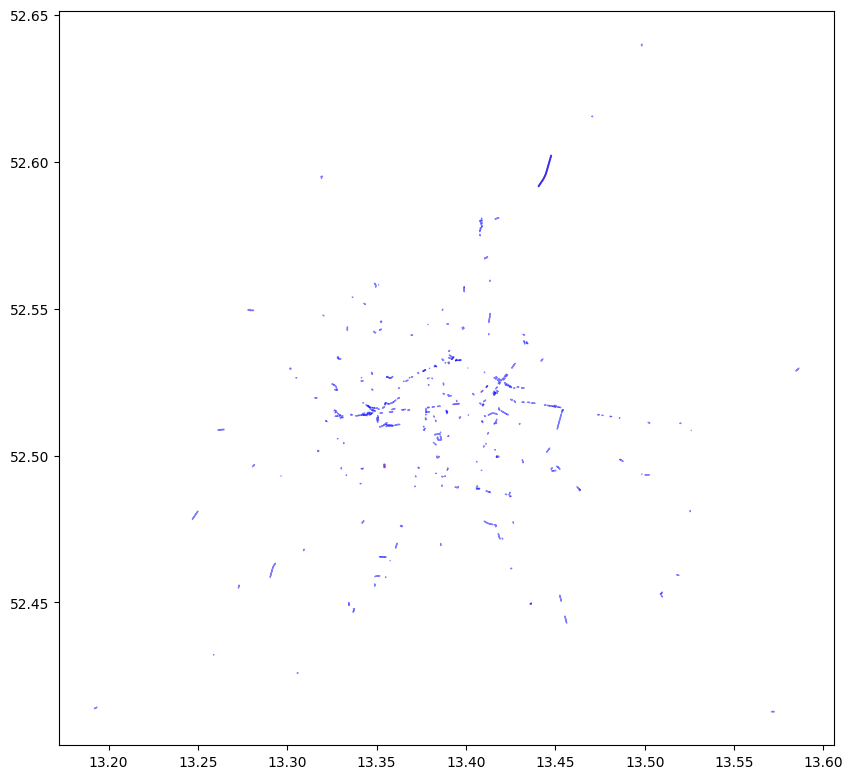

In [31]:
# Plotten der SimRa-Geometrien, die NaN enthalten
fig, ax = plt.subplots(figsize=(10, 10))
nan_values.plot(ax=ax, color='red', alpha=0.5, edgecolor='blue', label="NaN Geometries")

# osm_highway.plot(ax=ax, color='blue', alpha=0.5, linewidth=1, label="OSM Highways")

### Erklärung der `NaN`-Werte in der räumlichen Verknüpfung 

Nach Durchführung der räumlichen Verknüpfung (Spatial Join) zwischen dem SimRa-Datensatz und den OSM-Straßendaten ergab unsere Analyse, dass einige Einträge `NaN`-Werte in der Spalte `highway` & `index_right` enthalten. Die `NaN`-Werte deuten darauf hin, dass für die Polygone (simra_data) keine passenden Straßengeometrien gefunden wurden. Mögliche Ursachen dafür:

1. *Räumliche Abdeckung*: Einige Polygone im SimRa-Datensatz könnten Bereiche abdecken, die nicht vollständig durch die OSM-Daten repräsentiert sind.
3. *Unterschiedliche Koordinatensysteme*: &rarr, in unserem Fall ausgeschlossen / Die Koordinatensysteme wurden überprüft.

#### Umgang mit NaN-Werten
Detailliertere Überprüfungen sowie Visualisierungen haben gezeigt, dass die `NaN`-Werte in den betroffenen Geometrien existieren. Die Polygone, denen die NaN-Werte zugeordnet wurden, sind größtenteil kleine Wege, die neben Straßen oder in Grünflächen liegen.  
Um sicherzustellen, dass unsere Analyse präzise bleibt, werden die `NaN`-Werte entfernt, da sie keine nützlichen Informationen zu unserer Modellierung der Gefahrenscores beitragen.

# Entfernen der NaN-Werte

#### Bereinigung der Daten 

Um sicherzustellen, dass nur relevante Verknüpfungen in unserer Analyse betrachtet werden, entfernen wir Zeilen mit `NaN`-Werten in der `indexright`-Spalte. Das bedeutet, dass nur Zeilen mit gefundenen räumlichen Übereinstimmungen beibehalten werden.

In [23]:
cleaned_intersections = intersections.dropna(subset=['highway'])

print(f"Anzahl der verbleibenden Zeilen nach dem Entfernen der NaN-Werte: {len(cleaned_intersections)}")

Anzahl der verbleibenden Zeilen nach dem Entfernen der NaN-Werte: 85801


In [24]:
# Sicherstellen, dass keine NaN-Werte mehr in der Spalte 'index_right' vorhanden sind
nan_values_after_cleaning = cleaned_intersections[cleaned_intersections['index_right'].isna()]

print(f"Anzahl der NaN-Werte nach der Bereinigung: {len(nan_values_after_cleaning)}")

Anzahl der NaN-Werte nach der Bereinigung: 0


In [25]:
cleaned_intersections.shape

(85801, 9)

In [26]:
cleaned_intersections.head(3)

,id,type,score,incidents,rides,markers,geometry,index_right,highway
0,[79310].0,Street,0.0,0,57,[ ],"POLYGON ((13.3741 52.53031, 13.37421 52.5302, ...",170.0,residential
0,[79310].0,Street,0.0,0,57,[ ],"POLYGON ((13.3741 52.53031, 13.37421 52.5302, ...",33845.0,residential
0,[79310].0,Street,0.0,0,57,[ ],"POLYGON ((13.3741 52.53031, 13.37421 52.5302, ...",145435.0,residential


## Gruppieren der Polygone und Zusammenfassen der `highway´-Werte

Gruppieren und Aggregieren: 
- Der DataFrame wird nach `id` und `geometry` gruppiert. Für jede Gruppe werden die angegebenen Aggregationsfunktionen auf die Spalten angewendet:
  - Für `type`, `score`, `incidents`, `rides`, `markers`, und `index_right` wird der erste Wert in der Gruppe verwendet (`'first'`).
  - Für die `highway`-Spalte wird eine Funktion zum Kombinieren der Werte angwendet.
- Das Ergebnis ist ein DataFrame `grouped_data`, bei dem die `highway`-Werte pro Gruppe als zusammenhängender String dargestellt sind, während alle anderen spezifischen Werte beibehalten werden.

In [27]:
cleaned_intersections = gpd.GeoDataFrame(cleaned_intersections, geometry='geometry')

In [28]:
# Funktion zum Kombinieren der 'highway'-Werte 
def combine_highways(x):
    return ', '.join(x)  # Doppelte Einträge bleiben erhalten und werden verbunden

# Gruppieren nach 'id' und 'geometry' und Aggregation
grouped_data = cleaned_intersections.groupby(['id', 'geometry']).agg({
    'type': 'first',       # Erster Wert (da alle Werte gleich)
    'score': 'first',      
    'incidents': 'first',  
    'rides': 'first',      
    'markers': 'first',    
    'index_right': 'first',
    'highway': combine_highways  # Kombinieren der 'highway' Werte
}).reset_index()

In [29]:
# Umwandlung zurück in ein GeoDataFrame
grouped_data = gpd.GeoDataFrame(grouped_data, geometry='geometry', crs=cleaned_intersections.crs)

In [30]:
grouped_data.head(3)

,id,geometry,type,score,incidents,rides,markers,index_right,highway
0,[100049].0,"POLYGON ((13.45412 52.54035, 13.4532 52.53977,...",Street,0.0,0,138,[ ],57832.0,"secondary, secondary, cycleway, secondary"
1,[100069498].0,"POLYGON ((13.52273 52.50704, 13.52248 52.5069,...",Junction,0.0,0,200,[ ],123443.0,"residential, residential, residential"
2,"[100078509, 288268004, 3888645535].0","POLYGON ((13.47754 52.51457, 13.47782 52.51438...",Junction,0.0,0,54,[ ],75145.0,"secondary, secondary, cycleway, secondary, sec..."


In [31]:
# Spalte highway, Reihe 2 ausgeben 
grouped_data.loc[2, 'highway']

'secondary, secondary, cycleway, secondary, secondary, residential, cycleway, cycleway, residential, cycleway, cycleway, secondary, secondary'

In [32]:
grouped_data.shape

(15918, 9)

## Dummy-Variablen für die `highway`-Spalte erstellen

1. Zerlegen der `highway`-Spalte 
2. Berechnung der Anteile für jeden `highway`-Typ.
3. Erstellung der neuen Dummy-Variablen-Spalten.

#### 1. Zerlegen der `highway`-Spalte

In [33]:
# Zerlegen der 'highway'-Spalten in Listen
grouped_data['highway_list'] = grouped_data['highway'].apply(lambda x: x.split(', '))

In [34]:
grouped_data.head(3)

,id,geometry,type,score,incidents,rides,markers,index_right,highway,highway_list
0,[100049].0,"POLYGON ((13.45412 52.54035, 13.4532 52.53977,...",Street,0.0,0,138,[ ],57832.0,"secondary, secondary, cycleway, secondary","[secondary, secondary, cycleway, secondary]"
1,[100069498].0,"POLYGON ((13.52273 52.50704, 13.52248 52.5069,...",Junction,0.0,0,200,[ ],123443.0,"residential, residential, residential","[residential, residential, residential]"
2,"[100078509, 288268004, 3888645535].0","POLYGON ((13.47754 52.51457, 13.47782 52.51438...",Junction,0.0,0,54,[ ],75145.0,"secondary, secondary, cycleway, secondary, sec...","[secondary, secondary, cycleway, secondary, se..."


In [35]:
# Alle einzigartigen `highway`-Typen finden
unique_highways = sorted(set(sum(grouped_data['highway_list'].tolist(), [])))

In [36]:
print(unique_highways)

['cycleway', 'footway', 'highway_rare', 'living_street', 'path', 'primary', 'residential', 'secondary', 'service', 'tertiary', 'track']


#### 2. Berechnen und Zuordnen der Anteile der jeweiligen `highway`-Typen pro Polygon

In [37]:
# Funktion zur Berechnung der Anteilswerte - berechnet die Anteile der jeweiligen `highway`-Typen pro Zeile
def calculate_highway_ratios(row, highway_types):
    total_count = len(row['highway_list'])
    counts = pd.Series(row['highway_list']).value_counts()
    return {highway: counts.get(highway, 0) / total_count for highway in highway_types}

In [39]:
# Anwendung der Funktion auf den GeoDataFrame
highway_ratios = grouped_data.apply(calculate_highway_ratios, axis=1, highway_types=unique_highways) # axis=1 --> Fkt. wird aus Zeilen angewendet
ratios_df = pd.DataFrame(list(highway_ratios))

#### 3. Erstellen der neuen Dummy-Variablen (jeweils eine Spalte für jeden `highway`-Typ)

In [40]:
# Zusammenführen der Ergebnisse mit dem ursprünglichen GeoDataFrame
gdf = pd.concat([grouped_data, ratios_df], axis=1)

In [41]:
# Entfernen der temporären Spalte 'highway_list'
gdf.drop(columns=['highway_list'], inplace=True)

In [42]:
# gdf.drop(columns=['markers'], inplace=True)

In [43]:
gdf.head(3)

,id,geometry,type,score,incidents,rides,markers,index_right,highway,cycleway,footway,highway_rare,living_street,path,primary,residential,secondary,service,tertiary,track
0,[100049].0,"POLYGON ((13.45412 52.54035, 13.4532 52.53977,...",Street,0.0,0,138,[ ],57832.0,"secondary, secondary, cycleway, secondary",0.250000,0.0,0.0,0.0,0.0,0.0,0.000000,0.750000,0.0,0.0,0.0
1,[100069498].0,"POLYGON ((13.52273 52.50704, 13.52248 52.5069,...",Junction,0.0,0,200,[ ],123443.0,"residential, residential, residential",0.000000,0.0,0.0,0.0,0.0,0.0,1.000000,0.000000,0.0,0.0,0.0
2,"[100078509, 288268004, 3888645535].0","POLYGON ((13.47754 52.51457, 13.47782 52.51438...",Junction,0.0,0,54,[ ],75145.0,"secondary, secondary, cycleway, secondary, sec...",0.384615,0.0,0.0,0.0,0.0,0.0,0.153846,0.461538,0.0,0.0,0.0


In [ ]:
# Speichern des gdf
output_filename = "../../data/processed_data/osm_highway_ratios.geojson"
# gdf.to_file(output_filename, driver='GeoJSON')

print(f"Datei gespeichert.")

### Ergebnis:
Die beiden Datensätze `filtered_osm_highway_v1` und `simra_within_berlin` wurden räumlich verknüpft und als GeoDataFrame gespeichert im Verezichnis data/data_processed gespeichert. 
